# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re
import spacy
import torch
import nltk
import transformers

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier
from tqdm.auto import tqdm
from sklearn.dummy import DummyClassifier
from nltk.stem import WordNetLemmatizer

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.isnull().sum()/df_reviews.shape[0]

tconst             0.000000
title_type         0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
end_year           0.000000
runtime_minutes    0.000000
is_adult           0.000000
genres             0.000000
average_rating     0.000042
votes              0.000042
review             0.000000
rating             0.000000
sp                 0.000000
pos                0.000000
ds_part            0.000000
idx                0.000000
dtype: float64

In [8]:
df_reviews.duplicated().sum()

0

In [9]:
df_reviews = df_reviews.dropna()

# Conclusion

With 47331 entries, a small fraction of some columns were missing. This have been dropped as they would have no impact on the model. There were no duplicated entries in the data.

## EDA

Let's check the number of movies and reviews over years.

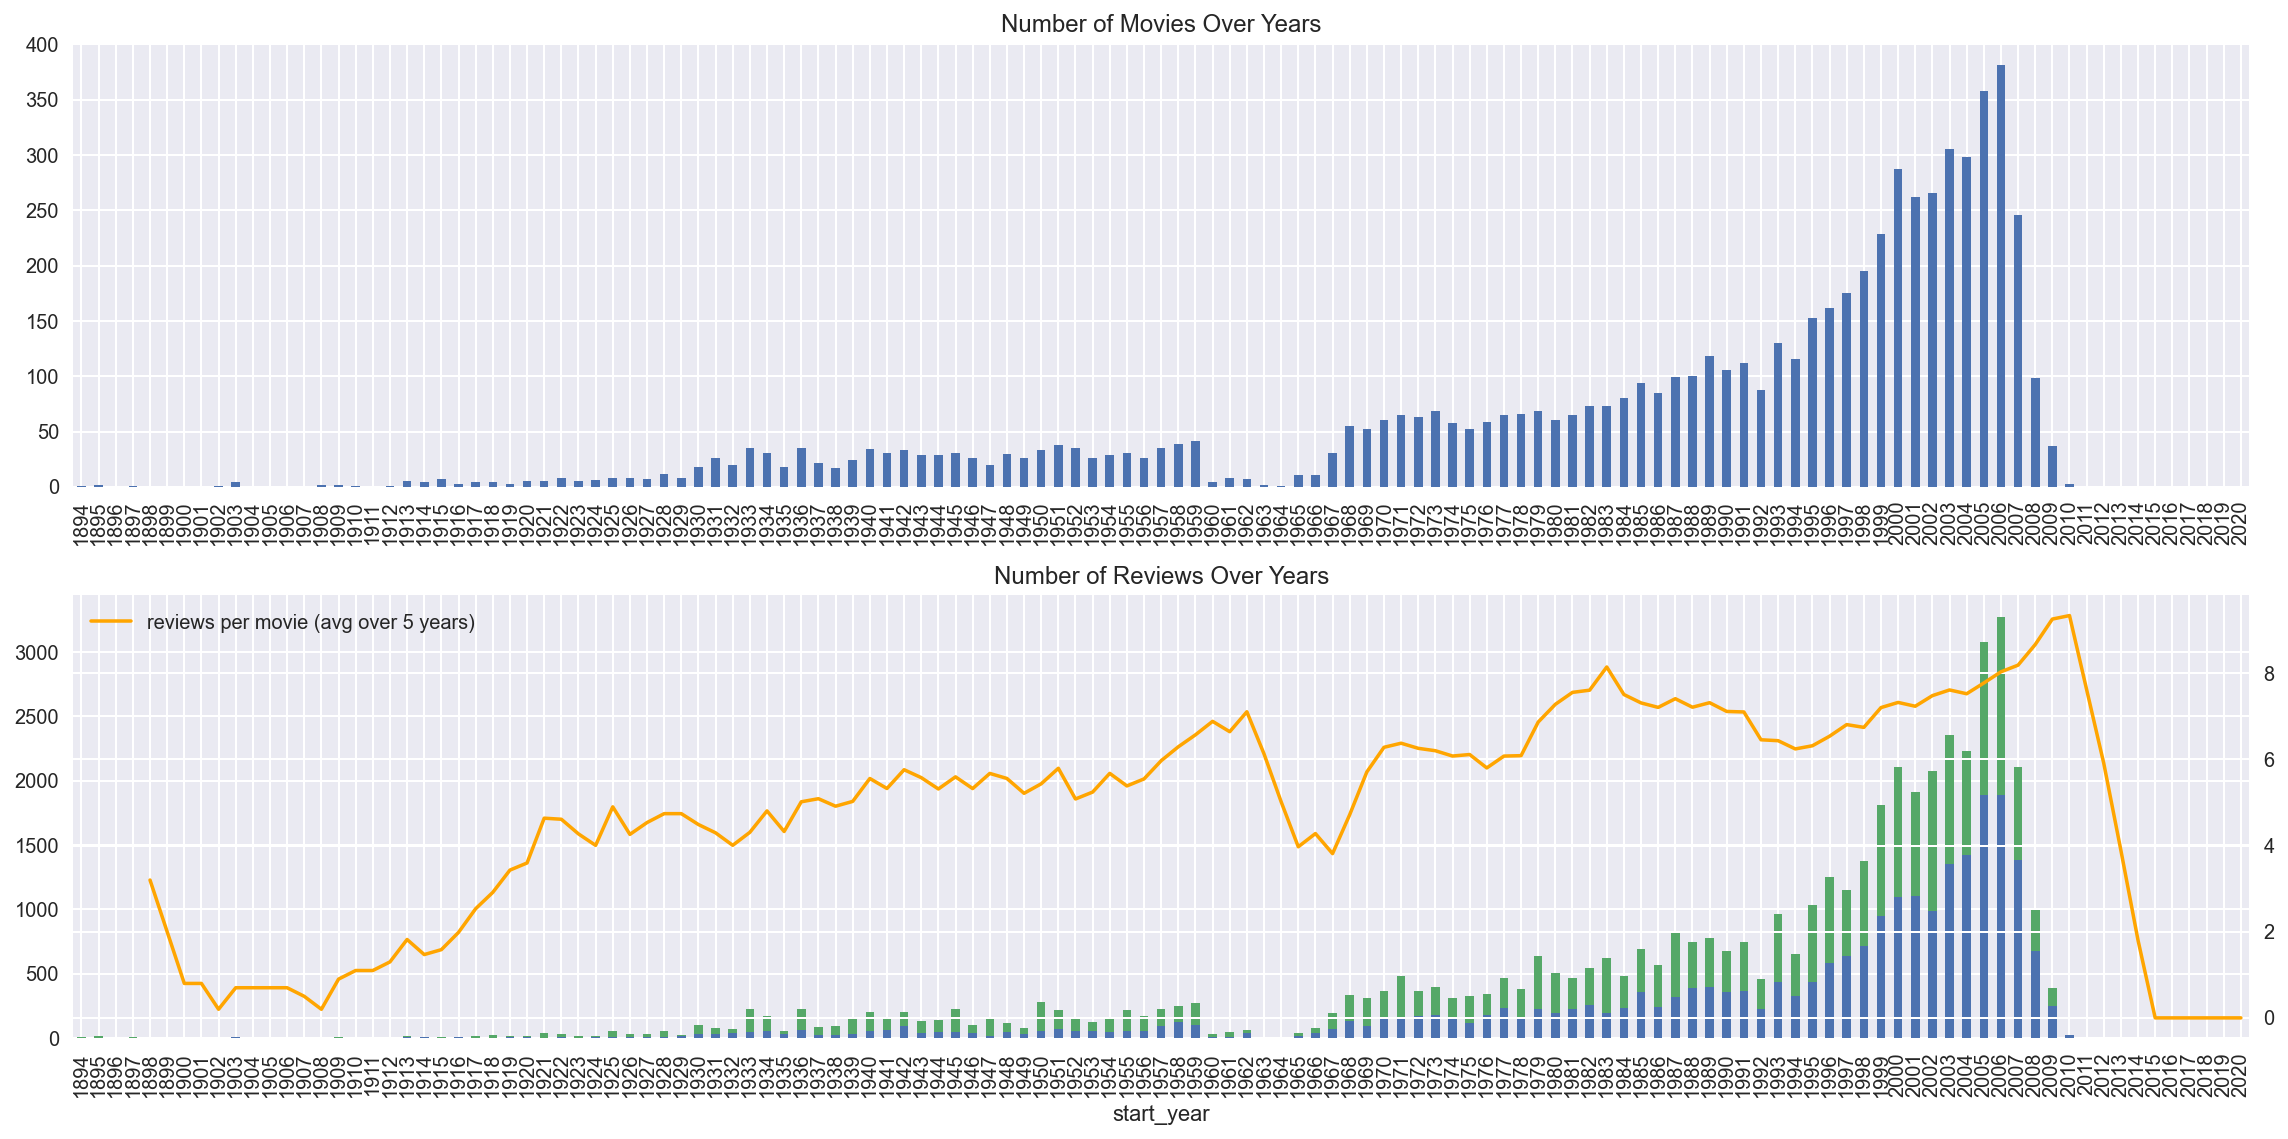

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
(dft3.reset_index(drop=True)
 .rolling(5).mean().plot(color='orange', 
                         label='reviews per movie (avg over 5 years)', ax=axt))

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

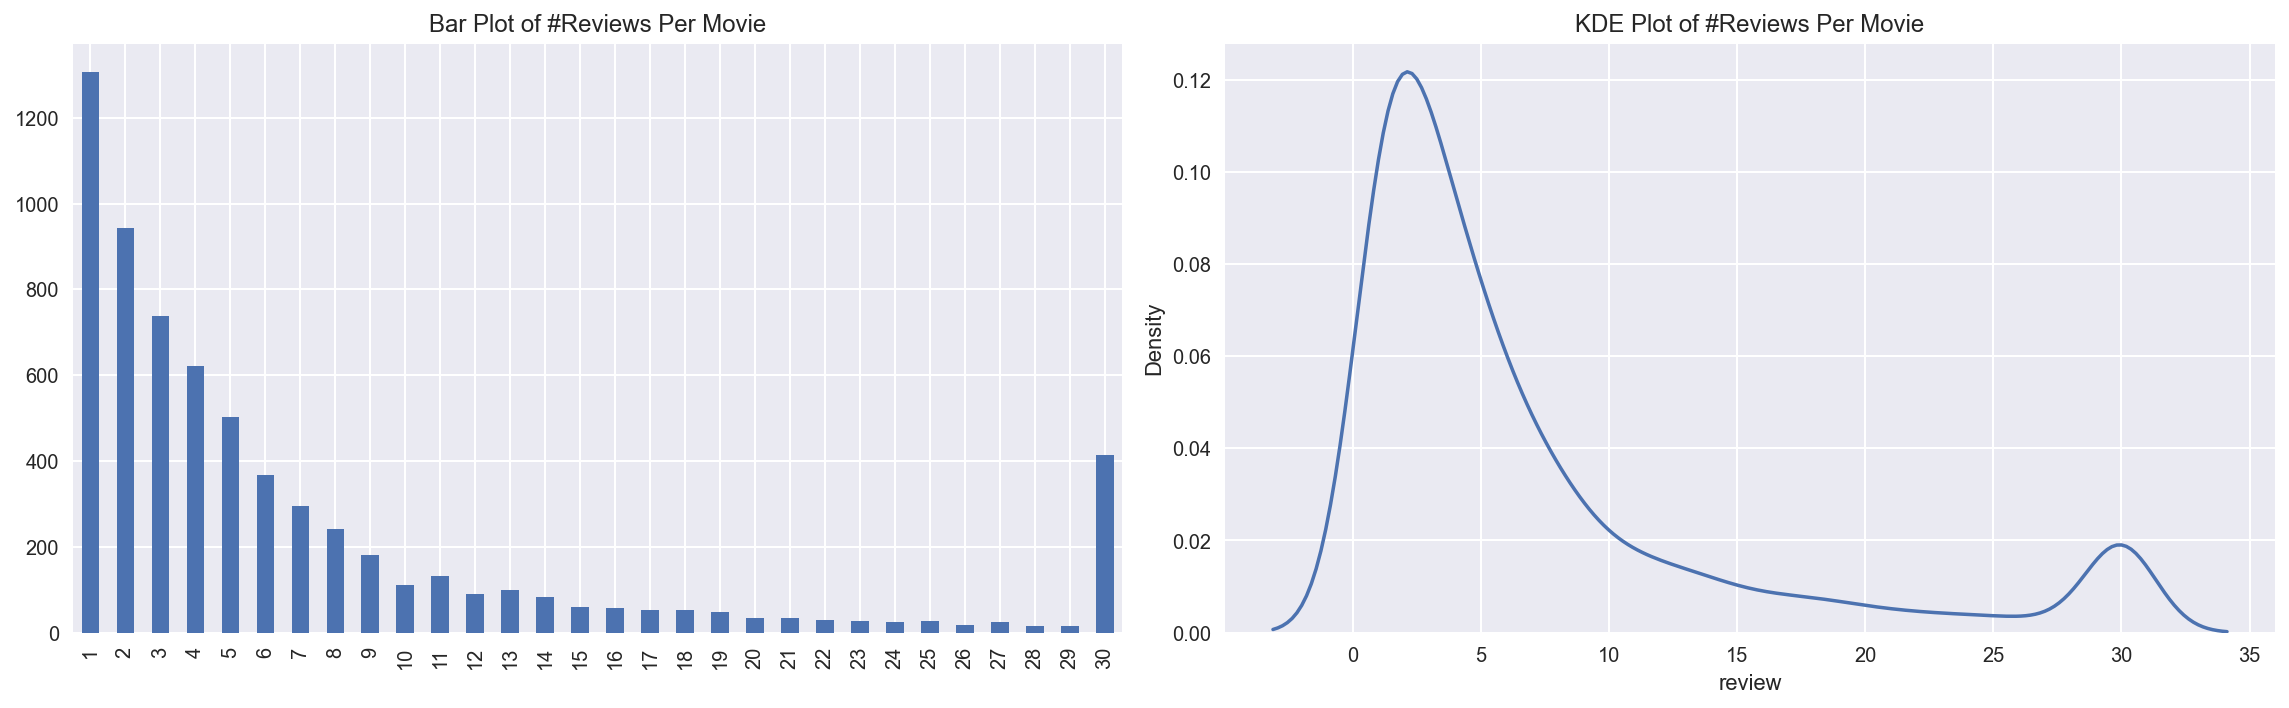

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

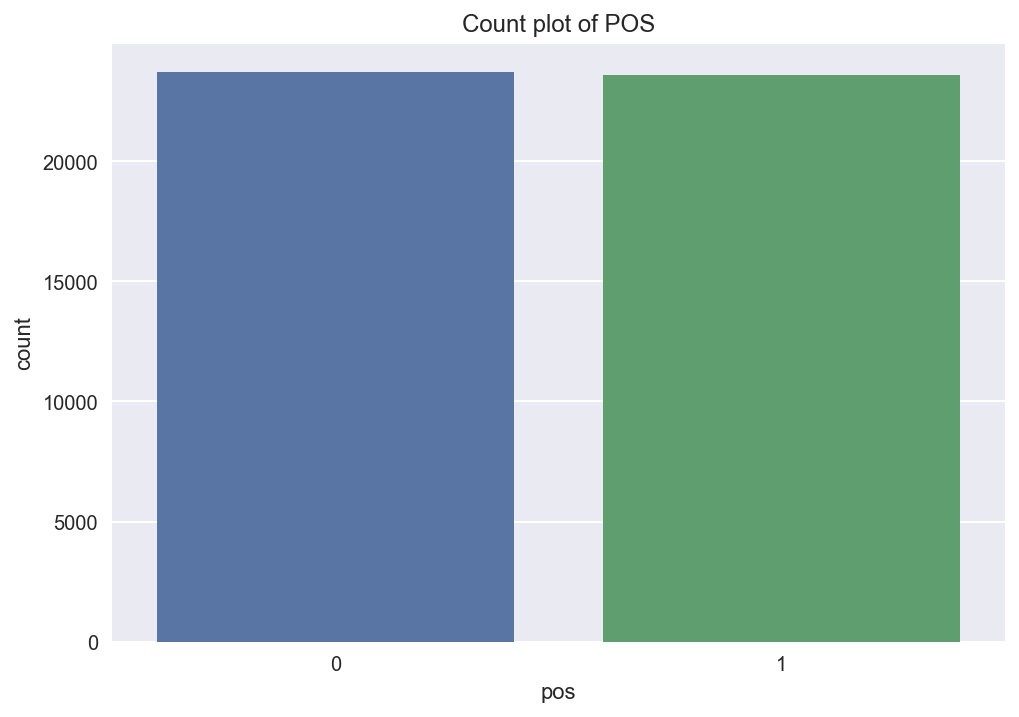

In [13]:
sns.countplot(df_reviews.pos)
plt.title('Count plot of POS');

The proportion of positive and negative values are approximately the same.

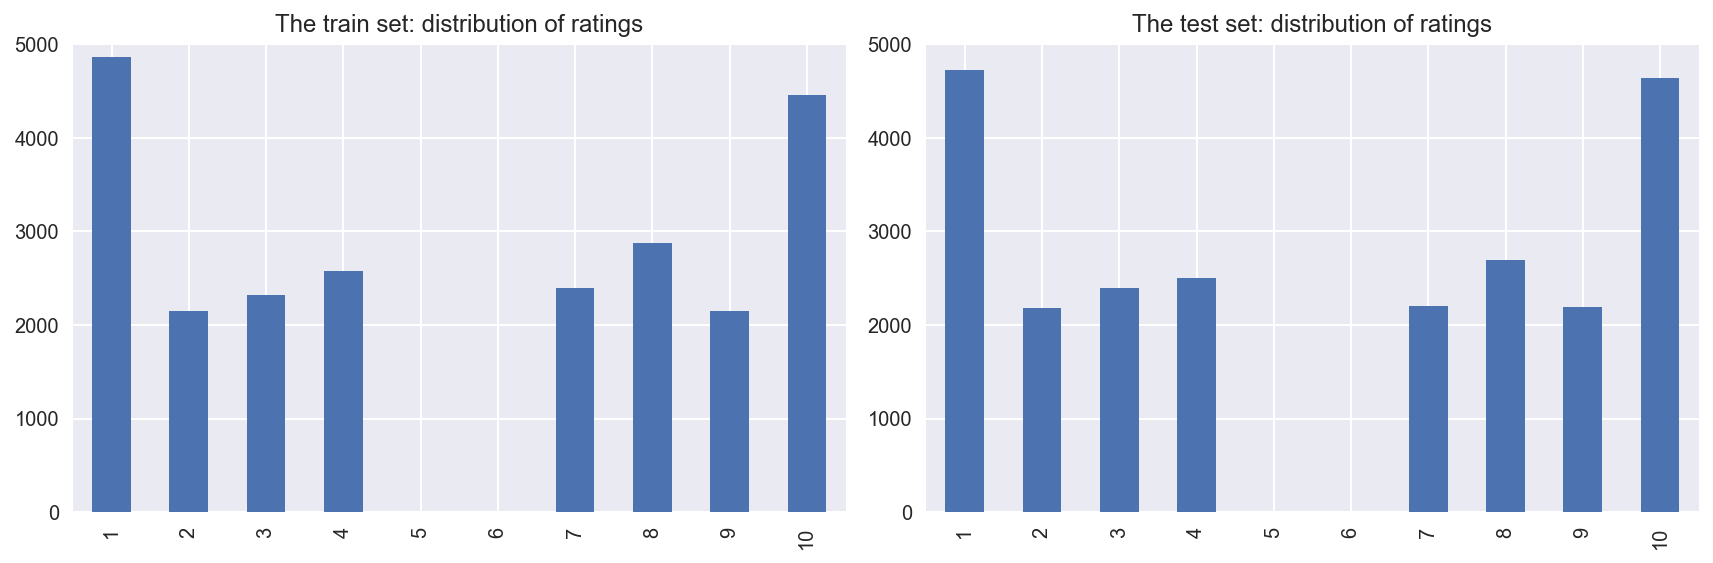

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

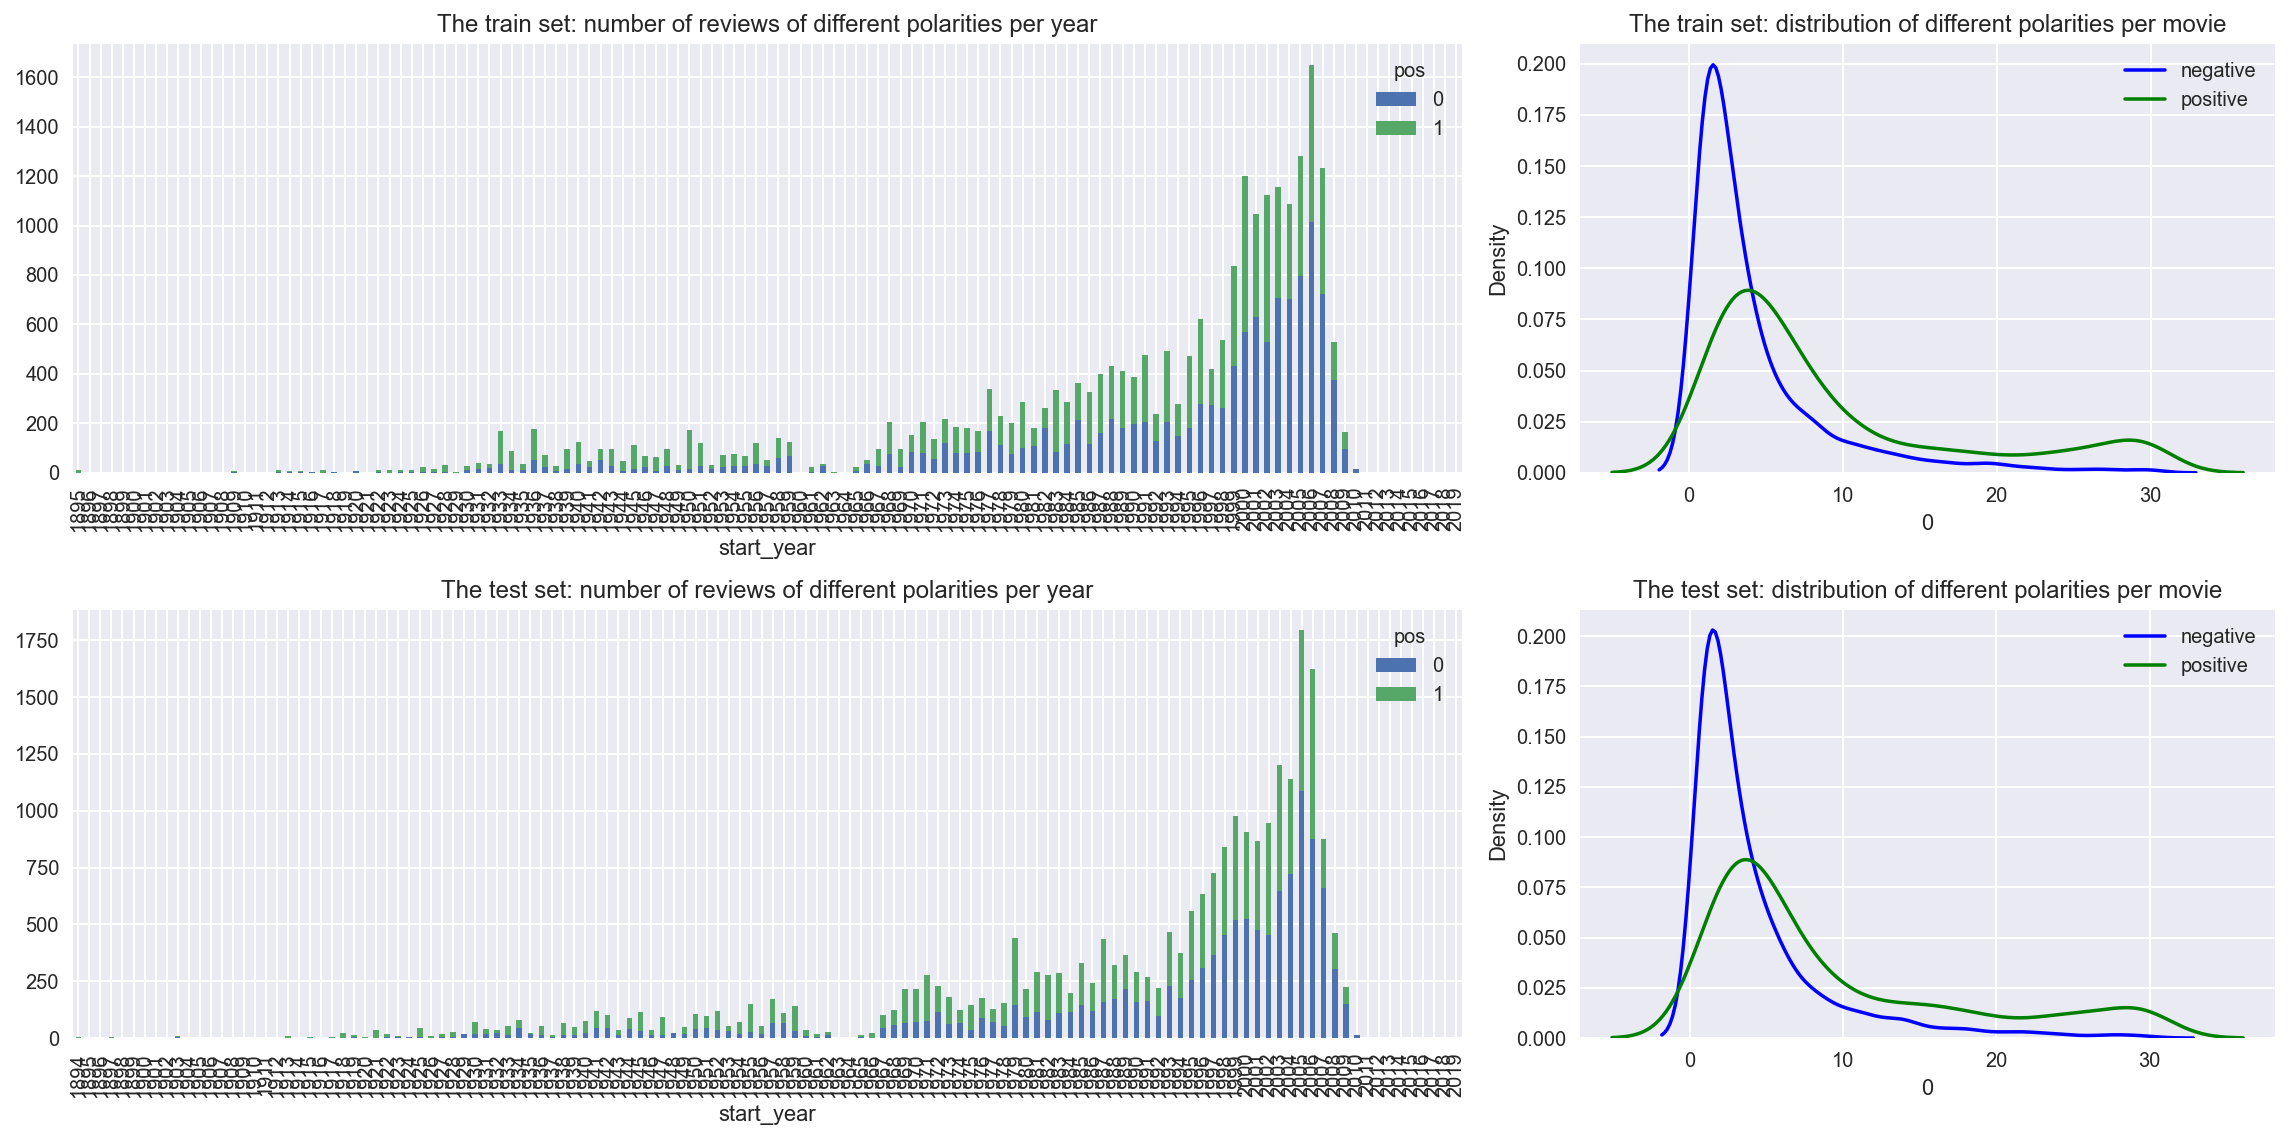

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

# Conclusion
The distribution of rating in both the training and test dataset are the same. This pattern is also present in the distribution of different movie popularities of the both test and training set which are both left skewed.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), 
                                   ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, 
                max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
def review_norm(df):
    text = re.sub(r'[^a-zA-Z\']',' ',df).split()
    text = " ".join(text).lower()
    return text
    
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x:review_norm(x))

In [18]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47329, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_y = df_reviews_train['pos']
test_y = df_reviews_test['pos']

train_x = df_reviews_train.review_norm
test_x = df_reviews_test.review_norm

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


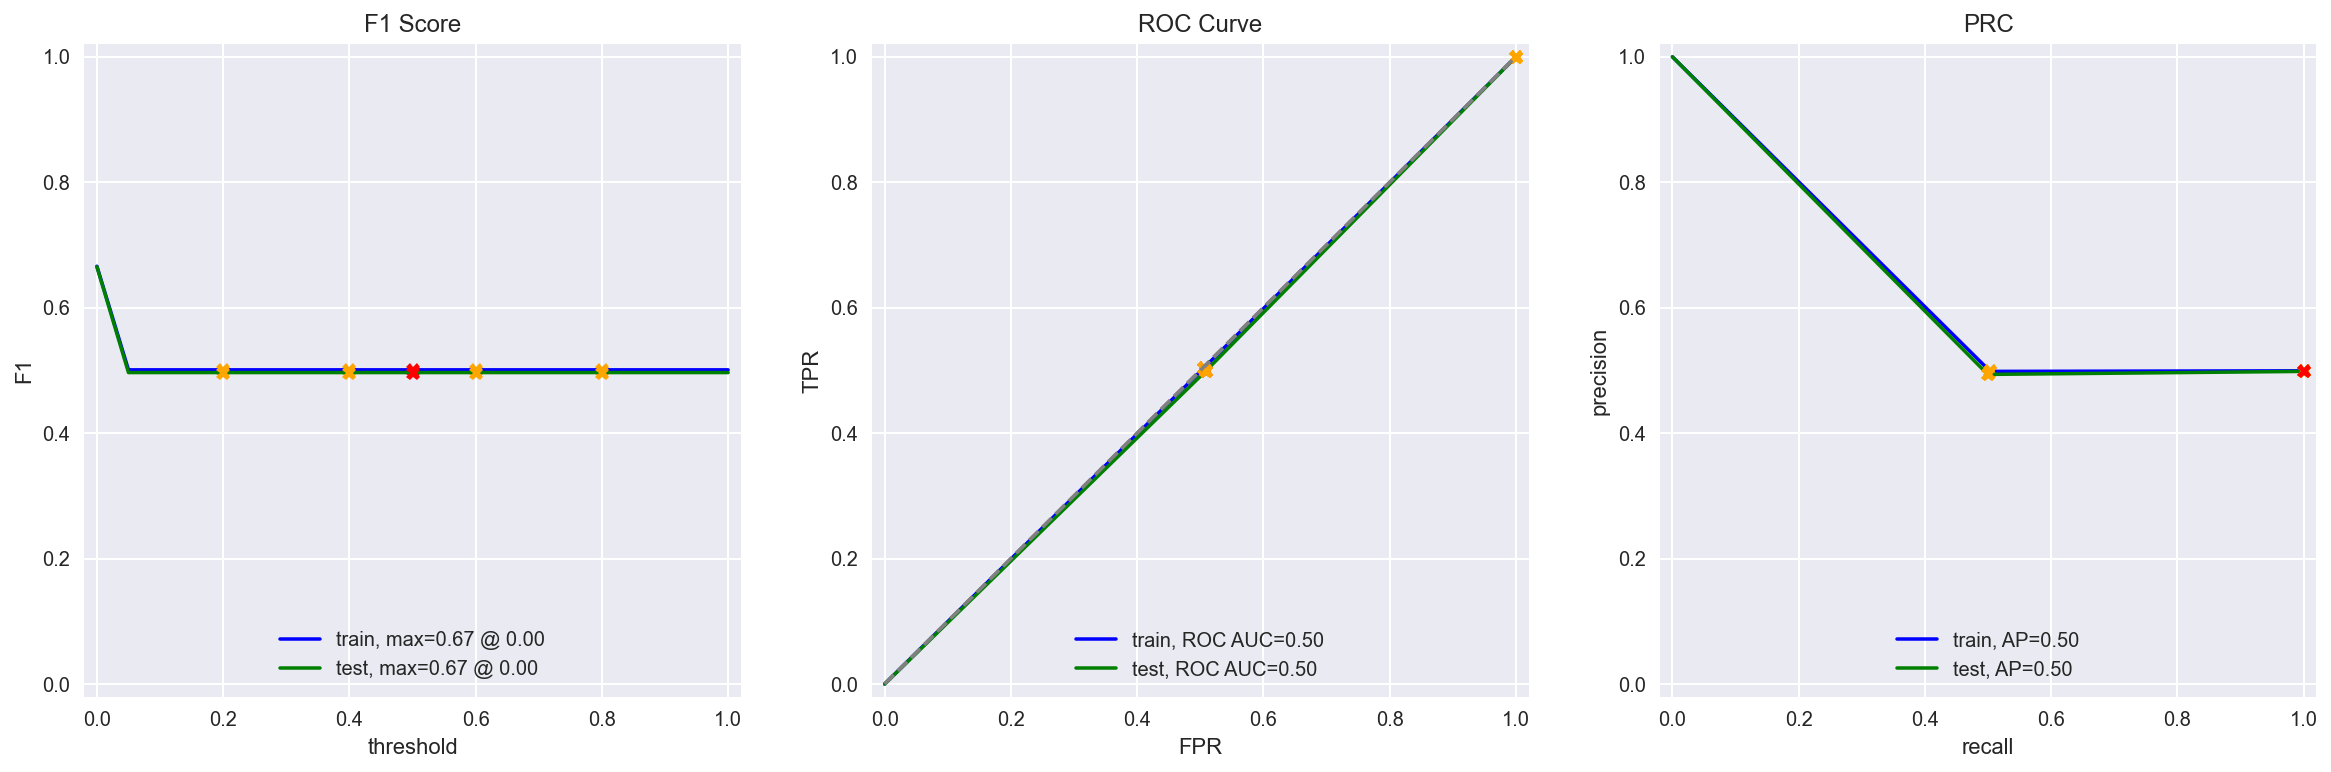

In [20]:
model = DummyClassifier(strategy = 'stratified',random_state =123)
model.fit(train_x,train_y)
evaluate_model(model, train_x, train_y, test_x, test_y)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [21]:
def lemmentized_word(corpus):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(corpus)
    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized

In [22]:
train_x_nltk = train_x.progress_apply(lemmentized_word)
test_x_nltk = test_x.progress_apply(lemmentized_word)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


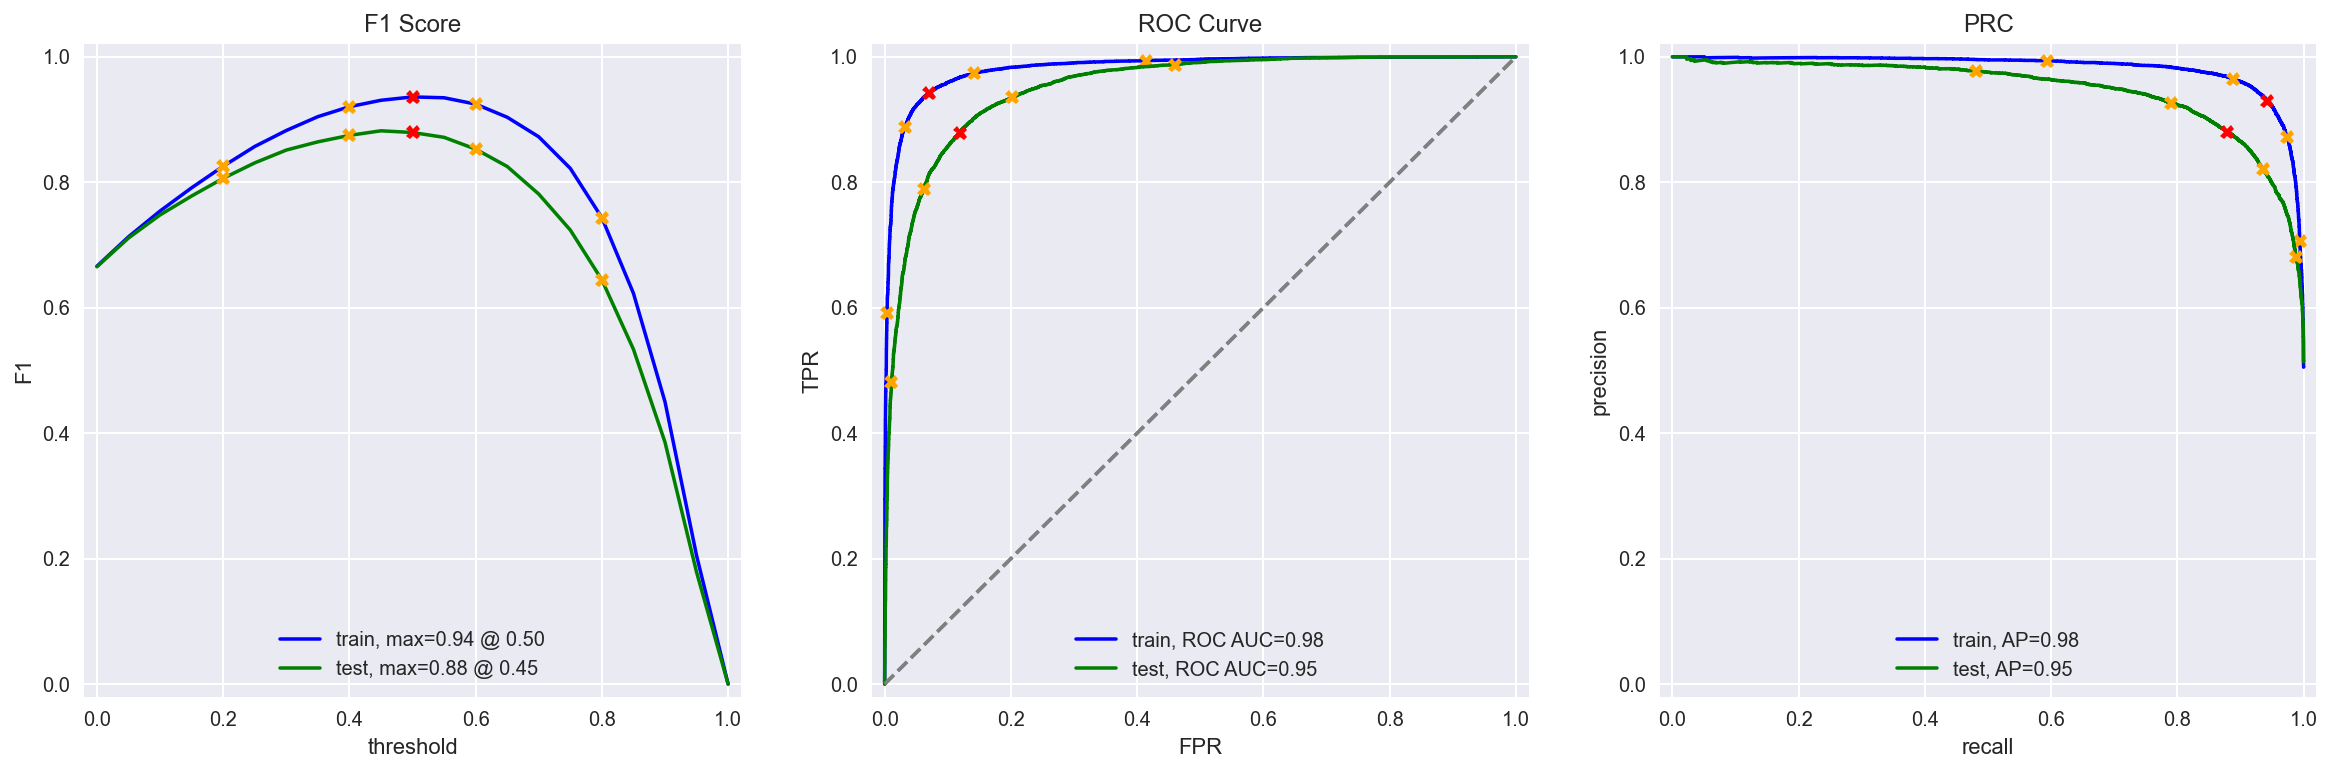

In [23]:
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = stop_words)

train_x_tfidf = count_tf_idf.fit_transform(train_x_nltk)
test_x_tfidf = count_tf_idf.transform(test_x_nltk)

lrt = LogisticRegression().fit(train_x_tfidf,train_y)

evaluate_model(lrt, train_x_tfidf, train_y, test_x_tfidf, test_y)

### Model 3 - spaCy, TF-IDF and LR

In [24]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


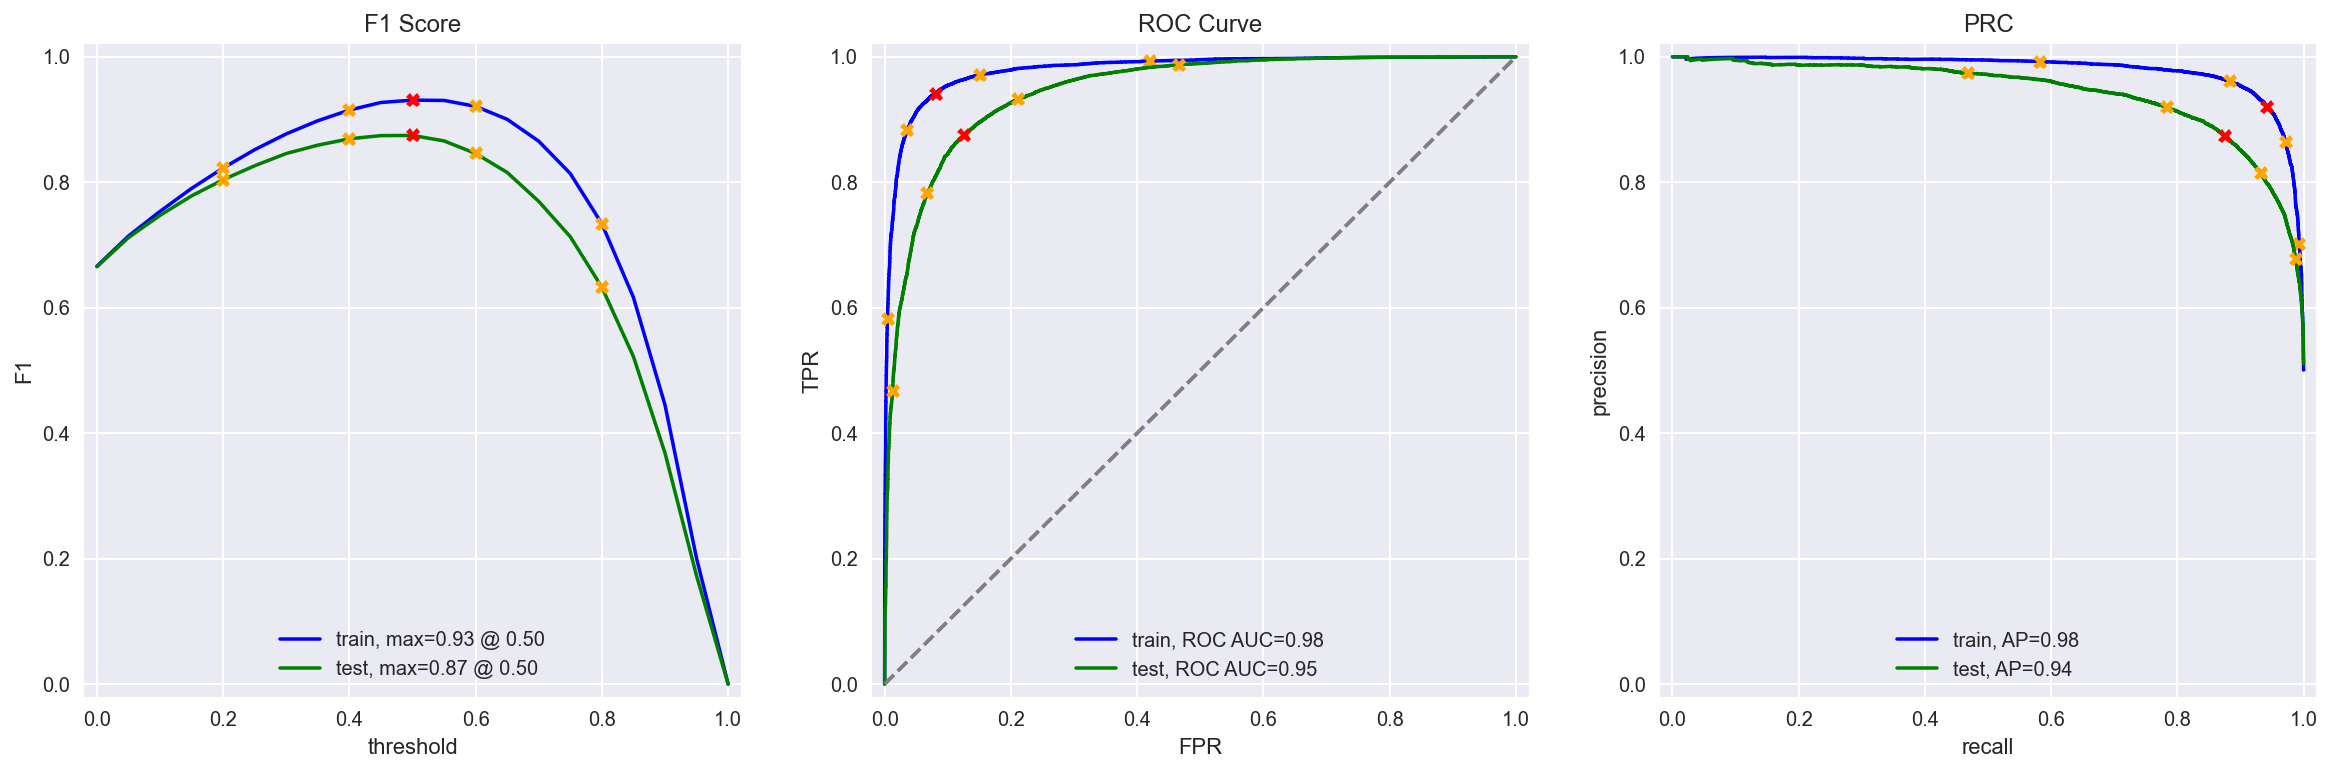

In [25]:
train_x_nlp = train_x.progress_apply(text_preprocessing_3)
test_x_nlp = test_x.progress_apply(text_preprocessing_3)

count_tf_spacy =  TfidfVectorizer(stop_words = stop_words)
train_x_nlp = count_tf_spacy.fit_transform(train_x_nlp)
test_x_nlp = count_tf_spacy.transform(test_x_nlp)

lrs = LogisticRegression().fit(train_x_nlp,train_y)

evaluate_model(lrs, train_x_nlp, train_y, test_x_nlp, test_y)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


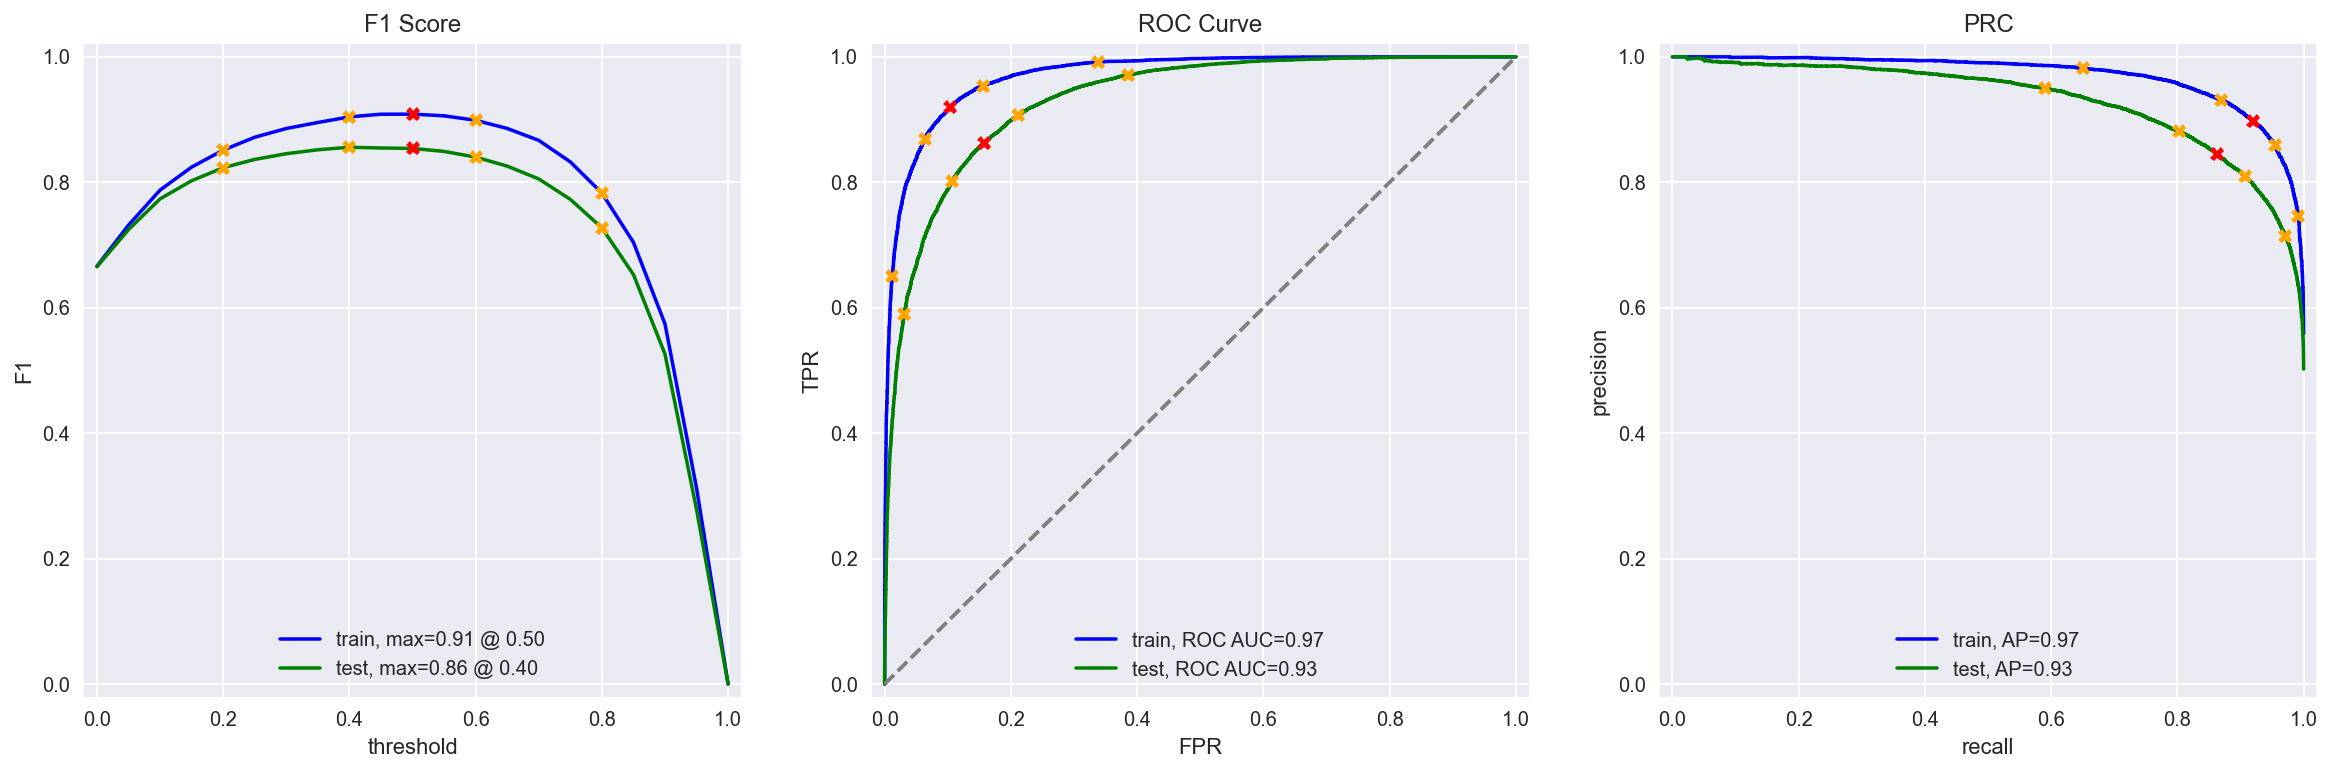

In [26]:
lgbm = LGBMClassifier(random_state=123).fit(train_x_nlp,train_y)

evaluate_model(lgbm, train_x_nlp, train_y, test_x_nlp, test_y)

###  Model 9 - BERT

In [27]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False):
   
    ids_list = []
    attention_mask_list = []

    for review in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(review, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    embeddings = []
    
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
                  
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    
    return np.concatenate(embeddings)

In [29]:
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cpu')

  0%|          | 0/23796 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/942 [00:00<?, ?it/s]

In [30]:
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


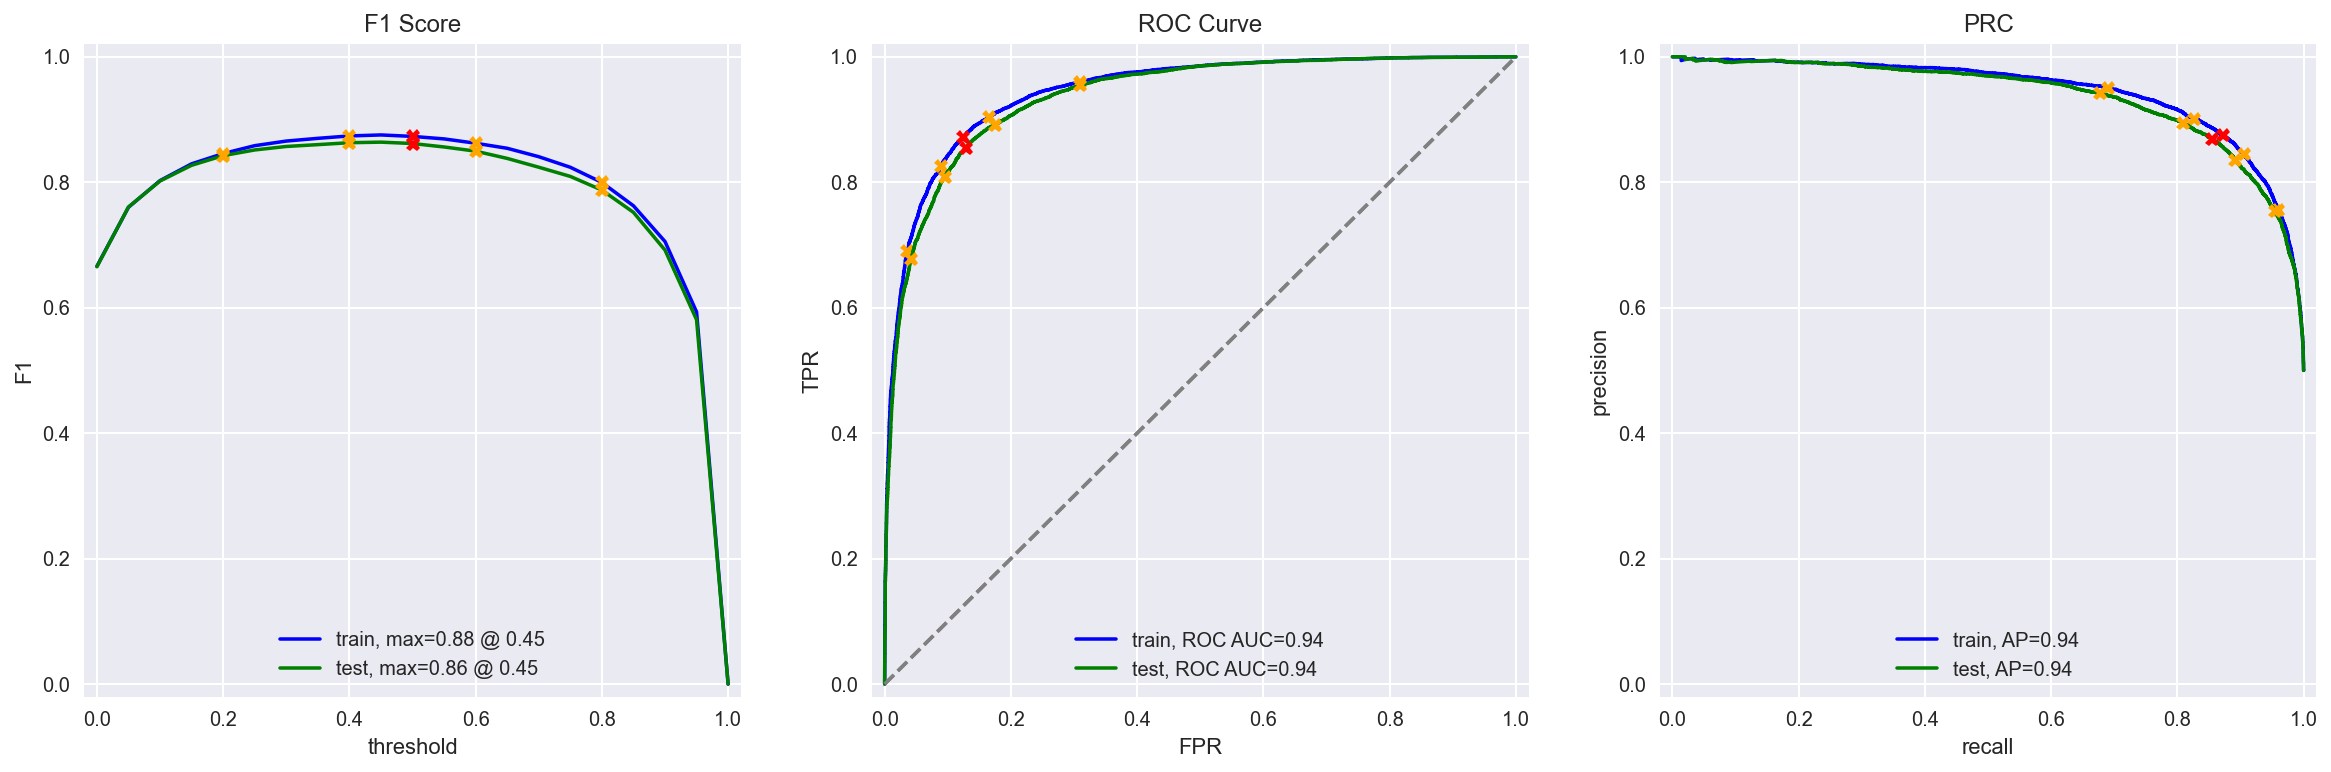

In [31]:
lrbert = LogisticRegression()

lrbert.fit(train_features_9, train_y)
evaluate_model(lrbert, train_features_9, train_y, test_features_9, test_y)

# Summary

||model|F1 Score Train|F1 score Test|
|---|---|---|---|
|1|DummyClassifier | 0.5|0.5|
|2|Logistic Regression TF-IDF|0.94|0.88|
|3|Logistic Regression Spacy|0.93|0.87|
|4|LightGBM |0.91|0.85|
|5|BERT |0.87|0.86|

## My Reviews

In [32]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(review_norm)

my_reviews.head()

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...


### Model 2

In [33]:
texts = my_reviews['review_norm'].apply(lemmentized_word)

my_reviews_pred_prob = lrt.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.14:  well i wa bored and felt asleep in the middle of the movie
0.46:  i wa really fascinated with the movie
0.12:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.30:  i did n't expect the reboot to be so good writer really cared about the source material
0.53:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Model 3

In [34]:
texts = my_reviews['review_norm'].apply(text_preprocessing_3)

my_reviews_pred_prob = lrs.predict_proba(count_tf_spacy.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  simply like kind movie
0.07:  bored feel asleep middle movie
0.52:  fascinated movie
0.14:  actor look old disintereste get pay movie soulless cash grab
0.23:  expect reboot good writer care source material
0.39:  movie upside downside feel like overall decent flick go
0.03:  rotten attempt comedy single joke land act annoying loud kid wo like
0.90:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama


### Model 4

In [35]:
texts = my_reviews['review_norm'].apply(text_preprocessing_3)

tfidf_vectorizer_4 = count_tf_spacy
my_reviews_pred_prob = lgbm.predict_proba(tfidf_vectorizer_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  simply like kind movie
0.31:  bored feel asleep middle movie
0.56:  fascinated movie
0.39:  actor look old disintereste get pay movie soulless cash grab
0.61:  expect reboot good writer care source material
0.52:  movie upside downside feel like overall decent flick go
0.27:  rotten attempt comedy single joke land act annoying loud kid wo like
0.74:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama


### Model 9

In [36]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = lrbert.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.36:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.25:  i didn't expect the reboot to be so good writers really cared about the source material
0.97:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

**Data Analysis and Exploration**
1. There were no duplicated data and the missing values in columns which were less than 0.01% were dropped from the dataset.
2. The ratio of positive and negative reviews were approximately the same in the pos column.
3. The number of movies are left skewed as they increased over the years to current date.
4. The reviews per movie are right skewed.
5. The distribution of ratings for both training and test data are approximately the same. 

**Final Results**

||model|F1 Score Train|F1 score Test|
|---|---|---|---|
|1|DummyClassifier | 0.5|0.5|
|2|Logistic Regression TF-IDF|0.94|0.88|
|3|Logistic Regression Spacy|0.93|0.87|
|4|LightGBM |0.91|0.85|
|5|BERT |0.87|0.86|

The best result is from **Logistic Regression TD-IDF with an F1 score of 94% and 88% for train and test data respectively.** When employed, would accurately filter and categorize movie reviews for The Film Junky Union. The other model results for the test set also did preform well, as their results ranging from 85% to 93% except for dummyclassifier with 0.5 for both the training and test set still meets Film Junky Union threshold of 85%.

Overall, the all models performed well is extracting, analyzing and prediction of the results. 

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions